In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, accuracy, KNNBasic, SVD, NMF, SlopeOne, CoClustering, BaselineOnly
from surprise.model_selection import cross_validate

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler 
from sklearn import model_selection

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

%matplotlib inline

In [2]:
df = pd.read_csv('Ecommerce_Data2.csv')

In [3]:
df = df.drop('Unnamed: 0',axis=1)

In [4]:
df['date'] = df['event_time'].apply(lambda x: x.split()[0])
df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d')
df = df[df['date']<pd.Timestamp('2019-10-6 00:00:00')]
df.to_csv('initialdf.csv')
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,date
0,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,2019-10-01
1,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,computers,2019-10-01
2,2019-10-01 00:00:19 UTC,view,1306631,2053013558920217191,computers.notebook,hp,580.89,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,2019-10-01
3,2019-10-01 00:00:22 UTC,view,1480714,2053013561092866779,computers.desktop,pulser,921.49,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,computers,2019-10-01
4,2019-10-01 00:00:37 UTC,view,1701111,2053013553031414015,computers.peripherals.monitor,acer,514.79,547028884,3ea7c620-a8d7-45c5-9ced-2e9874e2f549,computers,2019-10-01
...,...,...,...,...,...,...,...,...,...,...,...
356720,2019-10-05 23:59:20 UTC,view,1480584,2053013561092866779,computers.desktop,hp,984.20,514752680,d17778a4-d468-4c41-a17d-f3c47f739d8d,computers,2019-10-05
356721,2019-10-05 23:59:40 UTC,view,1480584,2053013561092866779,computers.desktop,hp,984.20,514752680,d17778a4-d468-4c41-a17d-f3c47f739d8d,computers,2019-10-05
356722,2019-10-05 23:59:50 UTC,view,1480171,2053013561092866779,computers.desktop,acer,823.67,514752680,d17778a4-d468-4c41-a17d-f3c47f739d8d,computers,2019-10-05
356723,2019-10-05 23:59:55 UTC,view,1306556,2053013558920217191,computers.notebook,lenovo,926.64,513465266,8576dd95-91d5-47c3-aa50-6220118fbd38,computers,2019-10-05


In [5]:
df['user_score'] = df['event_type'].map({'view':1,'cart':10,'purchase':50})
df['user_purchase'] = df['event_type'].apply(lambda x: 1 if x=='purchase' else 0)
df['price_category'] = 0
for i in df['category_code'].unique():
    df.loc[df['category_code']==i,'price_category'] = pd.qcut(x=df['price'][df['category_code']==i],q=5,labels=[1,2,3,4,5])
df    

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,date,user_score,user_purchase,price_category
0,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,2019-10-01,1,0,1
1,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,computers,2019-10-01,1,0,5
2,2019-10-01 00:00:19 UTC,view,1306631,2053013558920217191,computers.notebook,hp,580.89,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,2019-10-01,1,0,3
3,2019-10-01 00:00:22 UTC,view,1480714,2053013561092866779,computers.desktop,pulser,921.49,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,computers,2019-10-01,1,0,5
4,2019-10-01 00:00:37 UTC,view,1701111,2053013553031414015,computers.peripherals.monitor,acer,514.79,547028884,3ea7c620-a8d7-45c5-9ced-2e9874e2f549,computers,2019-10-01,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356720,2019-10-05 23:59:20 UTC,view,1480584,2053013561092866779,computers.desktop,hp,984.20,514752680,d17778a4-d468-4c41-a17d-f3c47f739d8d,computers,2019-10-05,1,0,5
356721,2019-10-05 23:59:40 UTC,view,1480584,2053013561092866779,computers.desktop,hp,984.20,514752680,d17778a4-d468-4c41-a17d-f3c47f739d8d,computers,2019-10-05,1,0,5
356722,2019-10-05 23:59:50 UTC,view,1480171,2053013561092866779,computers.desktop,acer,823.67,514752680,d17778a4-d468-4c41-a17d-f3c47f739d8d,computers,2019-10-05,1,0,4
356723,2019-10-05 23:59:55 UTC,view,1306556,2053013558920217191,computers.notebook,lenovo,926.64,513465266,8576dd95-91d5-47c3-aa50-6220118fbd38,computers,2019-10-05,1,0,4


In [62]:
df.to_csv('initialdf1.csv')

In [6]:
for i in df['category_code'].unique():
    df.loc[df['category_code']==i,'price_category'] = pd.qcut(x=df['price'][df['category_code']==i],q=5,labels=[1,2,3,4,5])

In [7]:
group = df.groupby(['user_id','product_id'])['user_score','user_purchase'].sum().reset_index()
group['user_purchase'] = group['user_purchase'].apply(lambda x: 1 if x>1 else x)
group['user_score'] = group['user_score'].apply(lambda x: 100 if x>100 else x)

In [8]:
std = MinMaxScaler(feature_range=(0.025, 1))
std.fit(group['user_score'].values.reshape(-1,1))
group['interaction_score'] = std.transform(group['user_score'].values.reshape(-1,1))

In [9]:
group = group.merge(df[['product_id','category_code','brand','price','price_category']].drop_duplicates('product_id'),on=['product_id'])

In [10]:
X_train_val, X_test = model_selection.train_test_split(group,test_size=0.2, random_state=42)

In [11]:
X_train, X_valid = model_selection.train_test_split(X_train_val,test_size=0.16, random_state=42)

In [12]:
X_valid1 = X_valid.copy()
X_valid2 = X_valid.copy()
X_train_val1 = X_train_val.copy()

In [13]:
product_cat = X_train[['product_id','price_category','category_code']].drop_duplicates('product_id')
product_cat = product_cat.sort_values(by='product_id')
product_cat

,product_id,price_category,category_code
169489,1303193,5,computers.notebook
154665,1303237,5,computers.notebook
194671,1304021,5,computers.notebook
195310,1304096,3,computers.notebook
125091,1304106,4,computers.notebook
...,...,...,...
140687,45500012,1,computers.notebook
172186,45500013,1,computers.notebook
163052,45500014,1,computers.notebook
172203,45500015,1,computers.notebook


In [14]:
product_cat_matrix = np.reciprocal(euclidean_distances(np.array(product_cat['price_category']).reshape(-1,1))+1)

In [15]:
euclidean_matrix = pd.DataFrame(product_cat_matrix,columns=product_cat['product_id'],index=product_cat['product_id'])

In [16]:
tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['category_code']))
dt_matrix = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())

In [17]:
cos_similar_matrix = pd.DataFrame(cosine_similarity(dt_matrix.values),columns=product_cat['product_id'],index=product_cat['product_id'])

In [18]:
similar_matrix = cos_similar_matrix.multiply(euclidean_matrix)

In [19]:
X_train_matrix = pd.pivot_table(X_train,values='user_score',index='user_id',columns='product_id')
X_train_matrix = X_train_matrix.fillna(0)

In [20]:
content_matrix = X_train_matrix.dot(similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix.values)
content_matrix = std.transform(content_matrix.values)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train['product_id'].unique()),index=sorted(X_train['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
X_valid = X_valid.merge(content_df,on=['user_id','product_id'])

In [21]:
X_valid['predicted_purchase'] = X_valid['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)

In [22]:
item_price_precision = precision_score(X_valid['user_purchase'],X_valid['predicted_purchase'])
item_price_precision

0.06818181818181818

In [23]:
item_price_recall = recall_score(X_valid['user_purchase'],X_valid['predicted_purchase'])
item_price_recall

0.05660377358490566

In [24]:
item_price_f1 = f1_score(X_valid['user_purchase'],X_valid['predicted_purchase'])
item_price_f1 

0.06185567010309278

In [25]:
content_matrix = X_train_matrix.dot(cos_similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix.values)
content_matrix = std.transform(content_matrix.values)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train['product_id'].unique()),index=sorted(X_train['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
X_valid1 = X_valid1.merge(content_df,on=['user_id','product_id'])

In [26]:
X_valid1['predicted_purchase'] = X_valid1['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)

In [27]:
item_precision = precision_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_precision

0.05511811023622047

In [28]:
item_recall = recall_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_recall

0.0440251572327044

In [29]:
item_f1 = f1_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_f1

0.048951048951048945

In [30]:
product_cat = X_train[['product_id','price_category','category_code','brand']].drop_duplicates('product_id')
product_cat = product_cat.sort_values(by='product_id')
product_cat

,product_id,price_category,category_code,brand
169489,1303193,5,computers.notebook,lenovo
154665,1303237,5,computers.notebook,dell
194671,1304021,5,computers.notebook,hp
195310,1304096,3,computers.notebook,dell
125091,1304106,4,computers.notebook,lenovo
...,...,...,...,...
140687,45500012,1,computers.notebook,deepcool
172186,45500013,1,computers.notebook,deepcool
163052,45500014,1,computers.notebook,deepcool
172203,45500015,1,computers.notebook,crown


In [31]:
tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['brand']))
dt_matrix1 = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())
dt_matrix1 = dt_matrix1 + 0.01

In [32]:
cos_similar_matrix1 = pd.DataFrame(cosine_similarity(dt_matrix1.values),columns=product_cat['product_id'],index=product_cat['product_id'])

In [33]:
similar_matrix = cos_similar_matrix.multiply(euclidean_matrix).multiply(cos_similar_matrix1)

In [34]:
X_train_matrix = pd.pivot_table(X_train,values='user_score',index='user_id',columns='product_id')
X_train_matrix = X_train_matrix.fillna(0)
content_matrix = X_train_matrix.dot(similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix.values)
content_matrix = std.transform(content_matrix.values)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train['product_id'].unique()),index=sorted(X_train['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
X_valid2 = X_valid2.merge(content_df,on=['user_id','product_id'])

In [35]:
X_valid2['predicted_purchase'] = X_valid2['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)

In [36]:
item_price_brand_precision = precision_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_precision

0.07391304347826087

In [37]:
item_price_brand_recall = recall_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_recall

0.05345911949685535

In [38]:
item_price_brand_f1 = f1_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_f1

0.06204379562043796

In [39]:
product_cat = X_train_val1[['product_id','price_category','category_code','brand']].drop_duplicates('product_id')
product_cat = product_cat.sort_values(by='product_id')
product_cat_matrix = np.reciprocal(euclidean_distances(np.array(product_cat['price_category']).reshape(-1,1))+1)
euclidean_matrix = pd.DataFrame(product_cat_matrix,columns=product_cat['product_id'],index=product_cat['product_id'])

tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['category_code']))
dt_matrix = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())
cos_similar_matrix = pd.DataFrame(cosine_similarity(dt_matrix.values),columns=product_cat['product_id'],index=product_cat['product_id'])

tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['brand']))
dt_matrix1 = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())
dt_matrix1 = dt_matrix1 + 0.01
cos_similar_matrix1 = pd.DataFrame(cosine_similarity(dt_matrix1.values),columns=product_cat['product_id'],index=product_cat['product_id'])

similar_matrix = cos_similar_matrix.multiply(euclidean_matrix).multiply(cos_similar_matrix1)
X_train_val_matrix = pd.pivot_table(X_train_val1,values='user_score',index='user_id',columns='product_id')
X_train_val_matrix = X_train_val_matrix.fillna(0)

In [40]:
content_matrix = X_train_val_matrix.dot(similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix.values)
content_matrix = std.transform(content_matrix.values)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train_val1['product_id'].unique()),index=sorted(X_train_val1['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
X_test = X_test.merge(content_df,on=['user_id','product_id'])
X_test['predicted_purchase'] = X_test['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)

In [41]:
precision = precision_score(X_test['user_purchase'],X_test['predicted_purchase'])
precision

0.07803468208092486

In [42]:
recall = recall_score(X_test['user_purchase'],X_test['predicted_purchase'])
recall

0.04963235294117647

In [43]:
f1 = f1_score(X_test['user_purchase'],X_test['predicted_purchase'])
f1

0.060674157303370786

In [44]:
X_test.sort_values(by='interaction_score',ascending=False).head(1000)

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category,predicted_interaction,predicted_purchase
7829,515583687,1307069,100,1,1.000000,computers.notebook,acer,513.81,3,2.132869e-02,0
12140,540561338,1600282,100,1,1.000000,computers.peripherals.printer,hp,38.35,1,2.541698e-02,0
4795,541659360,1307237,100,1,1.000000,computers.notebook,lenovo,257.38,1,1.124150e-02,0
5513,513845379,1307069,100,1,1.000000,computers.notebook,acer,513.81,3,4.954266e-02,0
1981,547028884,1701302,100,1,1.000000,computers.peripherals.monitor,samsung,427.01,5,3.146392e-01,0
21396,526721591,1307379,100,1,1.000000,computers.notebook,asus,385.85,2,1.721632e-01,0
2764,516067930,9200197,100,1,1.000000,computers.peripherals.keyboard,genius,20.46,3,4.333739e-05,0
16306,519422987,1307095,100,1,1.000000,computers.notebook,lenovo,385.85,2,4.238706e-01,0
17533,548760963,1307398,100,1,1.000000,computers.notebook,hp,457.93,2,7.228306e-02,0
8401,517294938,1307238,100,1,1.000000,computers.notebook,lenovo,303.46,1,4.040587e-02,0


In [45]:
sampleuser_trainval = X_train_val[X_train_val['user_id']==518044530]
sampleuser_trainval.to_csv('sampleuser_trainval.csv')
sampleuser_trainval

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category
543,518044530,1307237,6,0,0.074242,computers.notebook,lenovo,257.38,1
2063,518044530,1307366,54,1,0.546970,computers.notebook,lenovo,248.62,1
9017,518044530,1307067,100,1,1.000000,computers.notebook,lenovo,251.74,1
113488,518044530,1307316,1,0,0.025000,computers.notebook,lenovo,248.89,1
49036,518044530,1307188,100,1,1.000000,computers.notebook,hp,285.51,1
20103,518044530,1307370,52,1,0.527273,computers.notebook,acer,257.15,1


In [46]:
sampleuser_test = X_test[X_test['user_id']==518044530]
sampleuser_test.to_csv('sampleuser_test.csv')
sampleuser_test

,user_id,product_id,user_score,user_purchase,interaction_score,category_code,brand,price,price_category,predicted_interaction,predicted_purchase
7739,518044530,1307135,100,1,1.000000,computers.notebook,hp,320.35,1,0.595432,1
13096,518044530,1307356,1,0,0.025000,computers.notebook,asus,373.21,2,0.035718,0
16729,518044530,1306686,1,0,0.025000,computers.notebook,prestigio,257.15,1,0.104291,0
20097,518044530,1306185,2,0,0.034848,computers.notebook,acer,386.08,2,0.148099,0


In [47]:
sample = content_df[content_df['user_id']==518044530].sort_values(by='predicted_interaction',ascending=False).merge(group[['product_id','category_code','brand','price','price_category']].drop_duplicates('product_id'),on='product_id')
sample

,user_id,product_id,predicted_interaction,category_code,brand,price,price_category
0,518044530,45500022,0.691400,computers.notebook,trust,17.99,1
1,518044530,1306221,0.691400,computers.notebook,haier,324.31,1
2,518044530,1304995,0.623003,computers.notebook,lenovo,180.11,1
3,518044530,1307316,0.623003,computers.notebook,lenovo,248.89,1
4,518044530,1304627,0.623003,computers.notebook,lenovo,308.86,1
...,...,...,...,...,...,...,...
5360,518044530,5200144,0.000915,computers.ebooks,pocketbook,162.14,4
5361,518044530,5200145,0.000915,computers.ebooks,pocketbook,158.79,4
5362,518044530,5200135,0.000915,computers.ebooks,pocketbook,153.86,4
5363,518044530,5200132,0.000915,computers.ebooks,pocketbook,161.91,4


In [48]:
sampleuser_recommend = sample[sample['predicted_interaction']>=0.5].sample(10,random_state=0)
sampleuser_recommend.to_csv('sampleuser_recommend.csv')
sampleuser_recommend

,user_id,product_id,predicted_interaction,category_code,brand,price,price_category
22,518044530,1304392,0.623003,computers.notebook,lenovo,180.11,1
29,518044530,1307188,0.595432,computers.notebook,hp,285.51,1
16,518044530,1306818,0.623003,computers.notebook,lenovo,218.77,1
15,518044530,1307004,0.623003,computers.notebook,lenovo,290.61,1
11,518044530,1307068,0.623003,computers.notebook,lenovo,303.48,1
20,518044530,1307366,0.623003,computers.notebook,lenovo,248.62,1
26,518044530,1305998,0.595432,computers.notebook,hp,270.02,1
10,518044530,1307151,0.623003,computers.notebook,lenovo,329.46,1
25,518044530,1305583,0.595432,computers.notebook,hp,295.99,1
2,518044530,1304995,0.623003,computers.notebook,lenovo,180.11,1


In [49]:
model = ['Item-Based','Item/Price-Based','Item/Price/Brand-Based']
scoring = ['f1','precision','recall']
model_name = ['item','item_price','item_price_brand']
model_list = []

for i in model:
    for j in scoring:
        model_dic = {'Model': i,'Scoring':j, 'Score':eval('{0}_{1}'.format(model_name[model.index(i)],j))}
        model_list.append(model_dic)

In [50]:
model_df = pd.DataFrame(model_list)
model_df

,Model,Scoring,Score
0,Item-Based,f1,0.048951
1,Item-Based,precision,0.055118
2,Item-Based,recall,0.044025
3,Item/Price-Based,f1,0.061856
4,Item/Price-Based,precision,0.068182
5,Item/Price-Based,recall,0.056604
6,Item/Price/Brand-Based,f1,0.062044
7,Item/Price/Brand-Based,precision,0.073913
8,Item/Price/Brand-Based,recall,0.053459


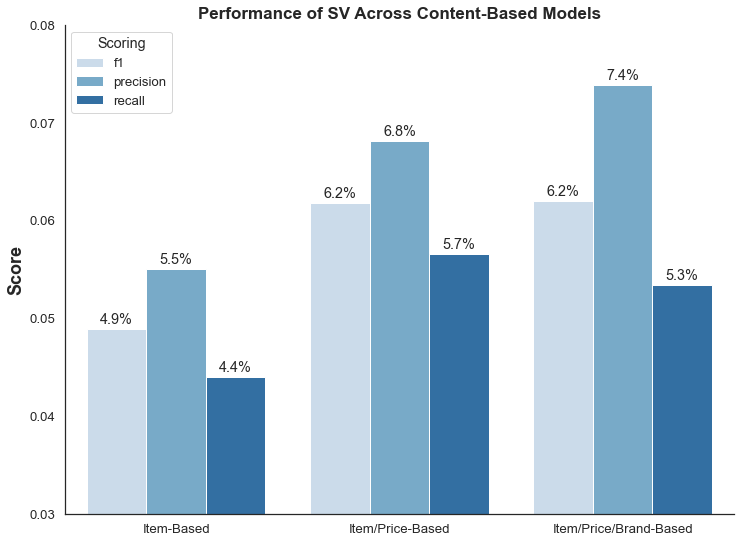

In [51]:
sns.set(style='white',font_scale=1.2)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='Score',data=model_df,hue='Scoring',palette='Blues')
for p in ax.patches:
        ax.annotate(str((p.get_height()*100).round(1))+'%', (p.get_x()+0.06, p.get_height()+0.0005))
plt.ylim([0.03,0.08])      
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Performance of SV Across Content-Based Models',weight='bold',fontsize=17)
sns.despine()
plt.savefig('barplot.png',transparent=True, bbox_inches='tight')

In [52]:
user_group = group.groupby('user_id')['user_purchase'].sum()
user_group = pd.DataFrame(user_group)
user_group.sort_values(by='user_purchase')

,user_purchase
user_id,
269253210,0
544036717,0
544037302,0
544038075,0
544038092,0
...,...
553005248,7
513842243,8
544431603,8


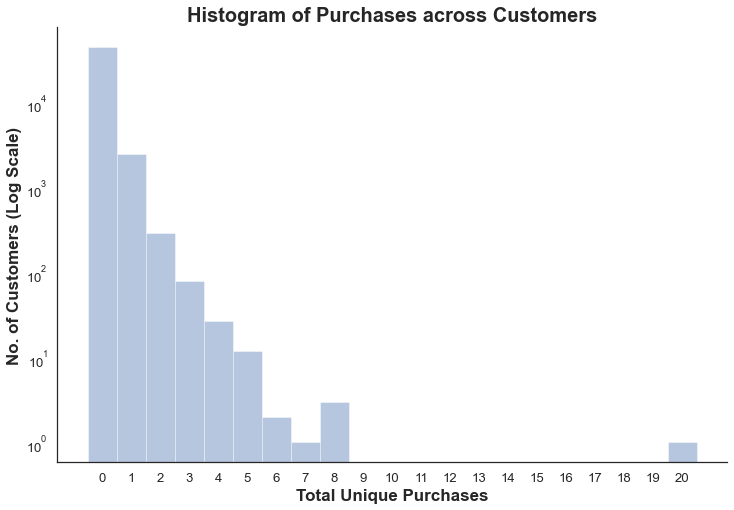

In [53]:
fig1 = plt.figure(figsize=[12,8])
ax1 = sns.distplot(user_group,bins=np.arange(22)-0.5,kde=False)
plt.yscale('log')
plt.xticks(range(0,21,1))
plt.ylabel('No. of Customers (Log Scale)',fontsize=17, weight='bold')
plt.xlabel('Total Unique Purchases', fontsize=17, weight='bold')
plt.title('Histogram of Purchases across Customers',weight='bold',fontsize=20)
sns.despine()
plt.savefig('hisplot.png',transparent=True, bbox_inches='tight')

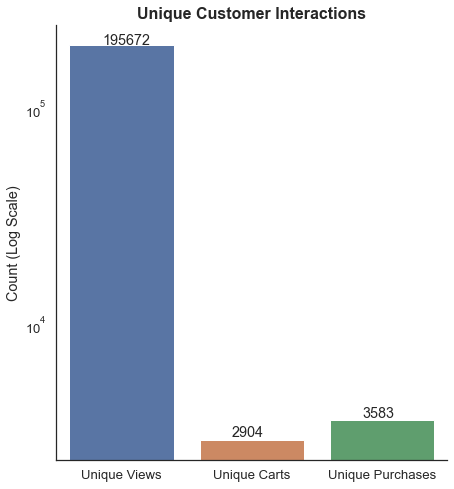

In [54]:
fig = plt.figure(figsize=[7,8])
ax = sns.countplot(df.drop_duplicates(subset=['user_id','product_id','event_type'])['event_type'])
plt.yscale('log')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.25, p.get_height()+100))
plt.xticks(ticks=[0,1,2],labels=['Unique Views','Unique Carts','Unique Purchases'])        
plt.xlabel('')   
plt.ylabel('Count (Log Scale)')
plt.title('Unique Customer Interactions',weight='bold',fontsize=16)
sns.despine()
plt.savefig('countplot.png',transparent=True, bbox_inches='tight')

In [55]:
user_purchase = []
for i in range(1,6):
    X_sub = X_test[X_test['user_id'].isin(list(X_test.groupby('user_id')['user_purchase'].sum().reset_index()[X_test.groupby('user_id')['user_purchase'].sum().reset_index()['user_purchase']==i]['user_id']))]
    recall = recall_score(X_sub['user_purchase'],X_sub['predicted_purchase'])
    precision = precision_score(X_sub['user_purchase'],X_sub['predicted_purchase'])
    user_purchase.append({'No. of Purchase':i,'Recall':recall,'Precision':precision})


In [56]:
user_purchase = pd.DataFrame(user_purchase)
user_purchase2 = user_purchase.stack().reset_index().rename(columns={'level_0':'No. of Purchase','level_1':'Metric', 0:'Score'})[user_purchase.stack().reset_index().rename(columns={'level_0':'No. of Purchase','level_1':'Metric', 0:'Score'})['Metric']!='No. of Purchase']
user_purchase2['No. of Purchase'] = user_purchase2['No. of Purchase'].apply(lambda x:x+1)
user_purchase2

,No. of Purchase,Metric,Score
1,1,Recall,0.033684
2,1,Precision,0.320000
4,2,Recall,0.038462
5,2,Precision,0.666667
7,3,Recall,1.000000
8,3,Precision,0.428571
10,4,Recall,1.000000
11,4,Precision,0.800000
13,5,Recall,0.200000
14,5,Precision,0.333333


In [57]:
user_purchase.stack().reset_index()

,level_0,level_1,0
0,0,No. of Purchase,1.000000
1,0,Recall,0.033684
2,0,Precision,0.320000
3,1,No. of Purchase,2.000000
4,1,Recall,0.038462
5,1,Precision,0.666667
6,2,No. of Purchase,3.000000
7,2,Recall,1.000000
8,2,Precision,0.428571
9,3,No. of Purchase,4.000000


In [58]:
user_group = X_test.groupby('user_id')['user_purchase'].sum()
user_group = pd.DataFrame(user_group)
user_group.sort_values(by='user_purchase')

,user_purchase
user_id,
340041246,0
541390450,0
541395210,0
541403562,0
541406638,0
...,...
519257034,2
544431603,3
553005248,4


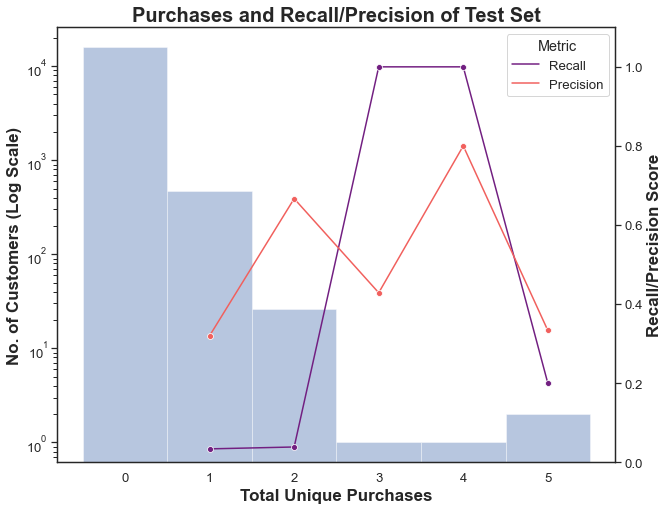

In [59]:
fig1 = plt.figure(figsize=[10,8])
ax1 = sns.distplot(user_group,bins=np.arange(7)-0.5,kde=False)
plt.yscale('log')
plt.xticks(range(0,6,1))
plt.ylabel('No. of Customers (Log Scale)',fontsize=17, weight='bold')
plt.xlabel('Total Unique Purchases', fontsize=17, weight='bold')
ax2 = plt.twinx()
sns.lineplot(x='No. of Purchase',y='Score',data=user_purchase2, hue='Metric',ax=ax2,marker='o',sort=False,palette='magma')
plt.ylim([0,1.1])
plt.ylabel('Recall/Precision Score',fontsize=17,weight='bold') 
plt.title('Purchases and Recall/Precision of Test Set',weight='bold',fontsize=20)
plt.savefig('mixplot.png',transparent=True, bbox_inches='tight')

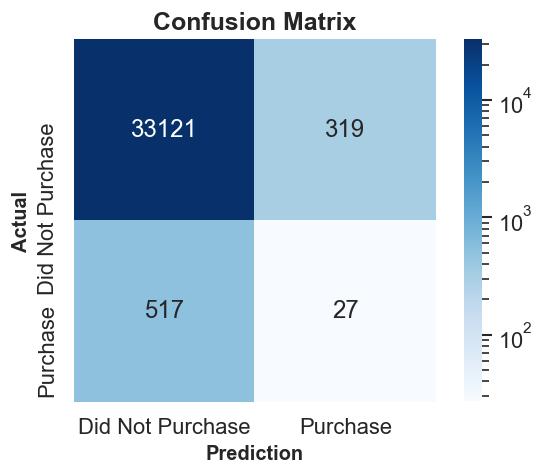

In [60]:
from matplotlib.colors import LogNorm
satisfaction_confusion = confusion_matrix(X_test['user_purchase'], X_test['predicted_purchase'])
plt.figure(dpi=120)
ax = sns.heatmap(satisfaction_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',norm=LogNorm(),
xticklabels=['Did Not Purchase', 'Purchase'],
yticklabels=['Did Not Purchase', 'Purchase']);   
plt.xlabel('Prediction',weight='bold',fontsize=12)
plt.ylabel('Actual',weight='bold',fontsize=12)
plt.title('Confusion Matrix',weight='bold',fontsize=15)
plt.savefig('confusionmatrix.png',transparent=True, bbox_inches='tight')

In [64]:
group.to_csv('groupdf.csv')